# Fine-Tuning Sentence Transformers untuk Essay Scoring

Notebook ini merupakan versi yang diperbaiki dengan:
1. **EDA (Exploratory Data Analysis)** yang lebih lengkap
2. **Train/Validation/Test Split** yang proper
3. **Data Preprocessing** dan cleaning
4. **Better Score Conversion** menggunakan regression/scaling
5. **Error Analysis** yang lebih mendalam
6. **Early Stopping** dan monitoring yang lebih baik

## Dataset
- Training: `financial_literacy_train.csv` (100 samples)
- Test: `financial_literacy_test.csv` (100 samples)


## 1. Import Libraries


In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
import re
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Dataset


In [18]:
# Load datasets
train_df = pd.read_csv("./dataset/financial_literacy_train.csv")
test_df = pd.read_csv("./dataset/financial_literacy_test.csv")

print("=" * 60)
print("DATASET LOADED")
print("=" * 60)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nScore range: {train_df['expected_score'].min()} - {train_df['expected_score'].max()}")

train_df.head()


DATASET LOADED
Training samples: 100
Test samples: 100

Columns: ['question', 'key_answer', 'student_answer', 'expected_score']

Score range: 0 - 96


,question,key_answer,student_answer,expected_score
0,What is financial literacy and why does it mat...,Financial literacy is the knowledge and skills...,Financial literacy refers to understanding how...,95
1,What is financial literacy and why does it mat...,Financial literacy is the knowledge and skills...,Financial literacy means knowing about money a...,60
2,What is financial literacy and why does it mat...,Financial literacy is the knowledge and skills...,Financial literacy is only about investing in ...,15
3,What is financial literacy and why does it mat...,Financial literacy is the knowledge and skills...,Financial literacy is a type of cooking skill ...,5
4,What are the four elements of financial well-b...,The four elements of financial well-being are:...,"According to the CFPB, financial well-being co...",94


## 3. Exploratory Data Analysis (EDA)


In [19]:
# Combine train and test for EDA
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Basic statistics
print("\n1. BASIC STATISTICS")
print(f"Total samples: {len(full_df)}")
print(f"\nScore Statistics:")
print(full_df['expected_score'].describe())

# Check for missing values
print("\n2. MISSING VALUES")
print(full_df.isnull().sum())

# Check for duplicates
print("\n3. DUPLICATE ROWS")
print(f"Duplicate rows: {full_df.duplicated().sum()}")

# Text length analysis
full_df['key_answer_length'] = full_df['key_answer'].str.len()
full_df['student_answer_length'] = full_df['student_answer'].str.len()
full_df['length_diff'] = abs(full_df['key_answer_length'] - full_df['student_answer_length'])

print("\n4. TEXT LENGTH ANALYSIS")
print(f"\nKey Answer Length:")
print(full_df['key_answer_length'].describe())
print(f"\nStudent Answer Length:")
print(full_df['student_answer_length'].describe())
print(f"\nLength Difference:")
print(full_df['length_diff'].describe())


EXPLORATORY DATA ANALYSIS

1. BASIC STATISTICS
Total samples: 200

Score Statistics:
count    200.000000
mean      40.775000
std       36.450067
min        0.000000
25%        7.250000
50%       32.500000
75%       69.500000
max       96.000000
Name: expected_score, dtype: float64

2. MISSING VALUES
question          0
key_answer        0
student_answer    0
expected_score    0
dtype: int64

3. DUPLICATE ROWS
Duplicate rows: 0

4. TEXT LENGTH ANALYSIS

Key Answer Length:
count    200.000000
mean     278.760000
std       23.513118
min      237.000000
25%      262.000000
50%      274.000000
75%      298.000000
max      316.000000
Name: key_answer_length, dtype: float64

Student Answer Length:
count    200.000000
mean     144.540000
std       52.776369
min       68.000000
25%      109.000000
50%      122.500000
75%      170.750000
max      301.000000
Name: student_answer_length, dtype: float64

Length Difference:
count    200.000000
mean     134.540000
std       56.111415
min        2.000

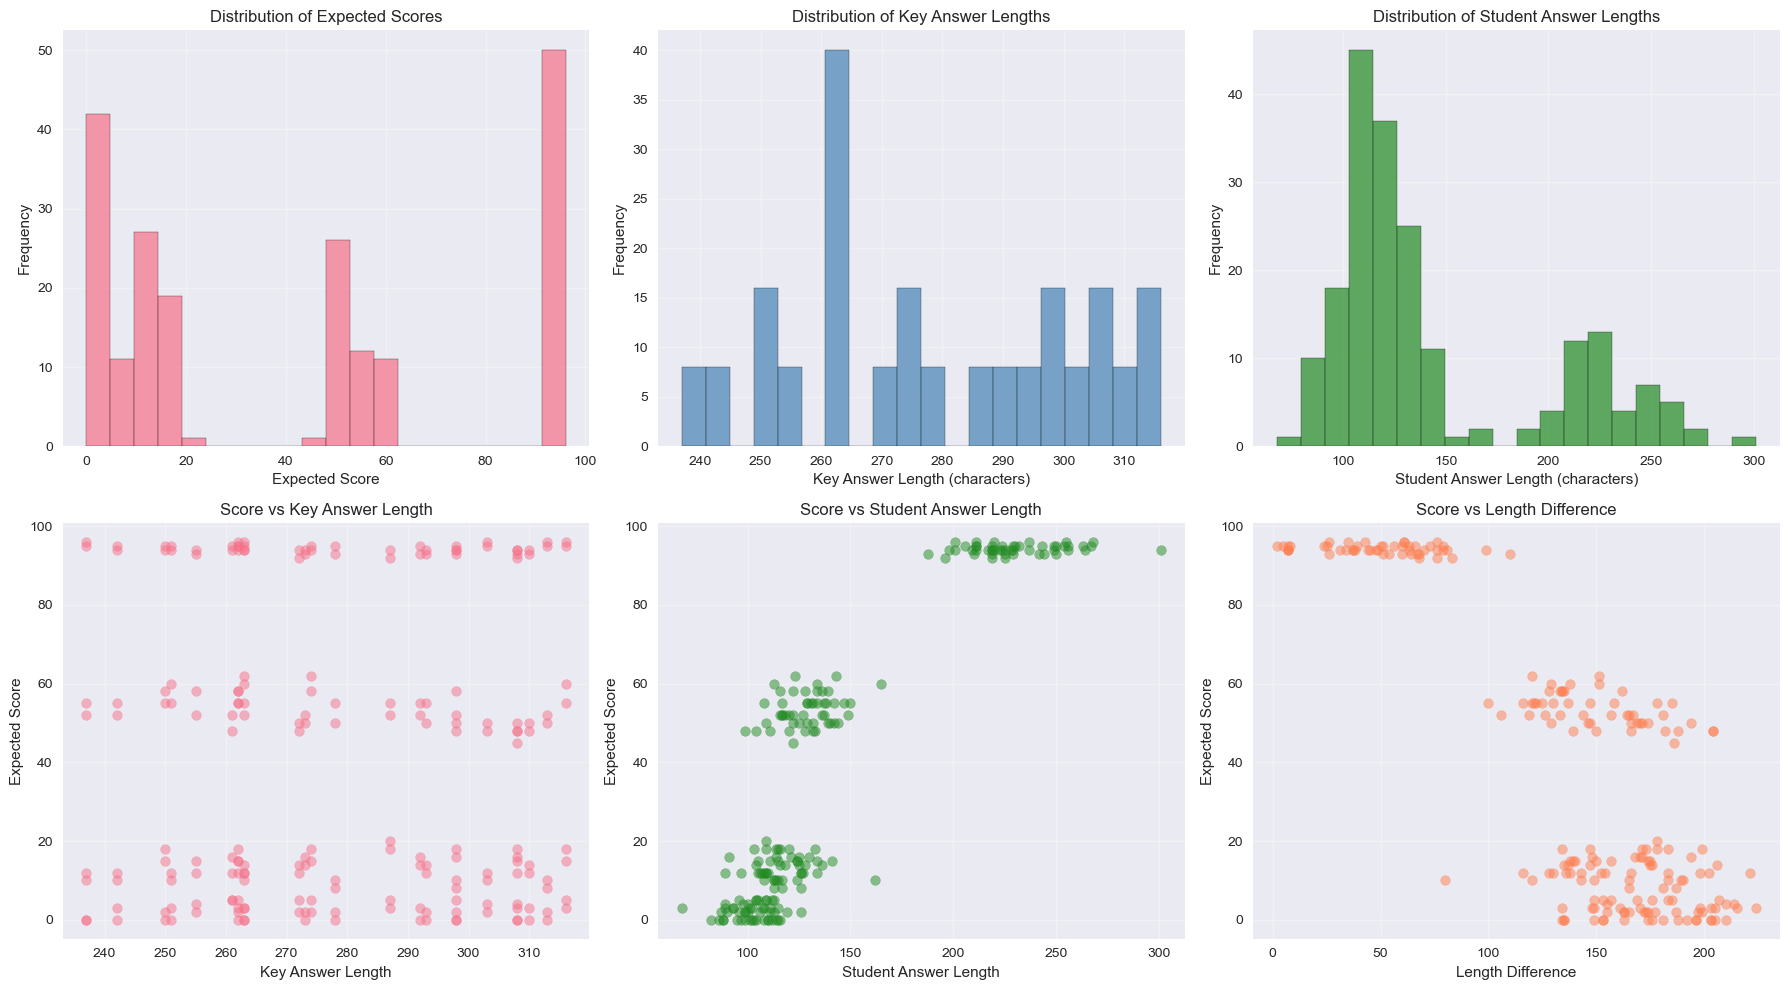


📊 EDA visualizations saved to: eda_analysis.png


In [20]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Score distribution
axes[0, 0].hist(full_df['expected_score'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Expected Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Expected Scores')
axes[0, 0].grid(True, alpha=0.3)

# Key answer length distribution
axes[0, 1].hist(full_df['key_answer_length'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_xlabel('Key Answer Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Key Answer Lengths')
axes[0, 1].grid(True, alpha=0.3)

# Student answer length distribution
axes[0, 2].hist(full_df['student_answer_length'], bins=20, edgecolor='black', alpha=0.7, color='forestgreen')
axes[0, 2].set_xlabel('Student Answer Length (characters)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Student Answer Lengths')
axes[0, 2].grid(True, alpha=0.3)

# Score vs Key Answer Length
axes[1, 0].scatter(full_df['key_answer_length'], full_df['expected_score'], alpha=0.5)
axes[1, 0].set_xlabel('Key Answer Length')
axes[1, 0].set_ylabel('Expected Score')
axes[1, 0].set_title('Score vs Key Answer Length')
axes[1, 0].grid(True, alpha=0.3)

# Score vs Student Answer Length
axes[1, 1].scatter(full_df['student_answer_length'], full_df['expected_score'], alpha=0.5, color='forestgreen')
axes[1, 1].set_xlabel('Student Answer Length')
axes[1, 1].set_ylabel('Expected Score')
axes[1, 1].set_title('Score vs Student Answer Length')
axes[1, 1].grid(True, alpha=0.3)

# Score vs Length Difference
axes[1, 2].scatter(full_df['length_diff'], full_df['expected_score'], alpha=0.5, color='coral')
axes[1, 2].set_xlabel('Length Difference')
axes[1, 2].set_ylabel('Expected Score')
axes[1, 2].set_title('Score vs Length Difference')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 EDA visualizations saved to: eda_analysis.png")


## 4. Data Preprocessing


In [21]:
def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', str(text))
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

# Apply cleaning
train_df['key_answer'] = train_df['key_answer'].apply(clean_text)
train_df['student_answer'] = train_df['student_answer'].apply(clean_text)
test_df['key_answer'] = test_df['key_answer'].apply(clean_text)
test_df['student_answer'] = test_df['student_answer'].apply(clean_text)

# Split training data into train and validation
# Menggunakan bins yang lebih sedikit untuk dataset kecil
# Cek distribusi score terlebih dahulu
score_bins = pd.cut(train_df['expected_score'], bins=3, labels=False)
bin_counts = pd.Series(score_bins).value_counts().sort_index()

print("Score distribution by bins:")
print(bin_counts)
print(f"\nMinimum samples per bin: {bin_counts.min()}")

# Jika ada bin dengan kurang dari 2 samples, tidak gunakan stratify
if bin_counts.min() >= 2:
    train_data, val_data = train_test_split(
        train_df,
        test_size=0.2,
        random_state=42,
        stratify=score_bins  # Stratify by score bins (3 bins)
    )
    print("\n✅ Using stratified split")
else:
    # Fallback: split tanpa stratify jika bins tidak cukup
    train_data, val_data = train_test_split(
        train_df,
        test_size=0.2,
        random_state=42
    )
    print("\n⚠️  Using non-stratified split (some bins have < 2 samples)")

print("=" * 60)
print("DATA PREPROCESSING COMPLETE")
print("=" * 60)
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTotal: {len(train_data) + len(val_data) + len(test_df)} samples")


Score distribution by bins:
expected_score
0    50
1    25
2    25
Name: count, dtype: int64

Minimum samples per bin: 25

✅ Using stratified split
DATA PREPROCESSING COMPLETE
Training samples: 80
Validation samples: 20
Test samples: 100

Total: 200 samples


## 5. Load Pre-trained Model & Define Evaluation Functions


In [22]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

print(f"Loading pre-trained model: {MODEL_NAME}")
pretrained_model = SentenceTransformer(MODEL_NAME)
print("Pre-trained model loaded!")

# Train a regression model to convert similarity to score
def train_score_converter(model, df):
    """Train a linear regression model to convert similarity to score"""
    similarities = []
    scores = []

    for idx, row in df.iterrows():
        embeddings = model.encode([row['key_answer'], row['student_answer']], convert_to_tensor=True)
        similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
        similarities.append(similarity)
        scores.append(row['expected_score'])

    # Train linear regression
    reg = LinearRegression()
    reg.fit(np.array(similarities).reshape(-1, 1), np.array(scores))

    return reg

def evaluate_model(model, df, score_converter=None, model_name="Model"):
    """
    Evaluate model performance on a dataset.
    Returns predictions and metrics.
    """
    predictions = []
    actuals = []
    similarities = []

    for idx, row in df.iterrows():
        # Encode dan hitung similarity
        embeddings = model.encode([row['key_answer'], row['student_answer']], convert_to_tensor=True)
        similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
        similarities.append(similarity)

        # Konversi similarity ke score
        if score_converter is not None:
            predicted_score = score_converter.predict([[similarity]])[0]
            # Clip to valid range
            predicted_score = np.clip(predicted_score, 0, 100)
        else:
            # Simple conversion (baseline)
            predicted_score = similarity * 100

        predictions.append(predicted_score)
        actuals.append(row['expected_score'])

    # Calculate metrics
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    similarities = np.array(similarities)

    correlation = np.corrcoef(predictions, actuals)[0, 1]
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f"\n{'='*50}")
    print(f"{model_name} Performance")
    print(f"{'='*50}")
    print(f"Correlation (r):     {correlation:.4f}")
    print(f"R² Score:            {r2:.4f}")
    print(f"RMSE:                {rmse:.4f}")
    print(f"MAE:                 {mae:.4f}")

    return {
        'predictions': predictions,
        'actuals': actuals,
        'similarities': similarities,
        'correlation': correlation,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }


Loading pre-trained model: sentence-transformers/all-MiniLM-L6-v2
Pre-trained model loaded!


## 6. Evaluate Pre-trained Model (Baseline)


In [23]:
# Train score converter on training data
print("Training score converter on training data...")
pretrained_score_converter = train_score_converter(pretrained_model, train_data)
print(f"Score converter trained. Coefficients: {pretrained_score_converter.coef_[0]:.2f}, Intercept: {pretrained_score_converter.intercept_:.2f}")

# Evaluate pre-trained model on VALIDATION data (not test!)
print("\nEvaluating pre-trained model on VALIDATION data...")
pretrained_val_results = evaluate_model(pretrained_model, val_data, pretrained_score_converter, "Pre-trained Model (Validation)")

# Evaluate pre-trained model on TEST data
print("\nEvaluating pre-trained model on TEST data...")
pretrained_test_results = evaluate_model(pretrained_model, test_df, pretrained_score_converter, "Pre-trained Model (Test)")


Training score converter on training data...
Score converter trained. Coefficients: 169.72, Intercept: -85.86

Evaluating pre-trained model on VALIDATION data...

Pre-trained Model (Validation) Performance
Correlation (r):     0.5601
R² Score:            0.3031
RMSE:                28.9973
MAE:                 23.4415

Evaluating pre-trained model on TEST data...

Pre-trained Model (Test) Performance
Correlation (r):     0.5669
R² Score:            0.2662
RMSE:                31.0217
MAE:                 25.3182


## 7. Prepare Data for Fine-tuning


In [24]:
# Prepare training examples untuk fine-tuning
train_examples = []

for idx, row in train_data.iterrows():
    # Konversi expected_score (0-100) ke similarity label (0-1)
    # Pastikan menggunakan float32 (bukan float64) untuk kompatibilitas dengan PyTorch
    similarity_label = np.float32(row['expected_score'] / 100.0)
    # Clip to valid range dan pastikan tetap float32
    similarity_label = np.clip(similarity_label, np.float32(0.0), np.float32(1.0))
    # Konversi ke Python float (tetap 32-bit)
    similarity_label = float(similarity_label)

    example = InputExample(
        texts=[row['key_answer'], row['student_answer']],
        label=similarity_label
    )
    train_examples.append(example)

print(f"Created {len(train_examples)} training examples")
print(f"\nExample:")
print(f"  Text 1: {train_examples[0].texts[0][:80]}...")
print(f"  Text 2: {train_examples[0].texts[1][:80]}...")
print(f"  Label:  {train_examples[0].label} (type: {type(train_examples[0].label)})")

# Prepare evaluator untuk monitoring training (gunakan VALIDATION set, bukan test!)
val_sentences1 = val_data['key_answer'].tolist()
val_sentences2 = val_data['student_answer'].tolist()
# Pastikan scores adalah float32
val_scores = [float(np.float32(score / 100.0)) for score in val_data['expected_score'].tolist()]  # Normalize to 0-1

evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sentences1,
    sentences2=val_sentences2,
    scores=val_scores,
    name="financial-literacy-val-eval"
)

print(f"\nEvaluator created with {len(val_sentences1)} validation samples")


Created 80 training examples

Example:
  Text 1: Zero-based budgeting means allocating every unit of income to a specific purpose...
  Text 2: In zero-based budgeting, you assign every dollar of income to specific categorie...
  Label:  0.949999988079071 (type: <class 'float'>)

Evaluator created with 20 validation samples


## 8. Fine-tune Model


In [25]:
# Load fresh model untuk fine-tuning
print(f"Loading fresh model for fine-tuning: {MODEL_NAME}")
finetuned_model = SentenceTransformer(MODEL_NAME)

# Create DataLoader
train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=16
)

# Define loss function
train_loss = losses.CosineSimilarityLoss(model=finetuned_model)

print(f"\nTraining Configuration:")
print(f"  Batch size: 16")
print(f"  Training samples: {len(train_examples)}")
print(f"  Validation samples: {len(val_data)}")
print(f"  Batches per epoch: {len(train_dataloader)}")

# Fine-tune the model
NUM_EPOCHS = 10
WARMUP_STEPS = int(len(train_dataloader) * NUM_EPOCHS * 0.1)  # 10% warmup
OUTPUT_PATH = "./finsmart-ai-finetuned-model"

print("\n" + "=" * 60)
print("STARTING FINE-TUNING")
print("=" * 60)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Output path: {OUTPUT_PATH}")
print("\n⚠️  Using VALIDATION set for evaluation during training")
print("\nTraining...\n")

finetuned_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=NUM_EPOCHS,
    warmup_steps=WARMUP_STEPS,
    evaluator=evaluator,
    evaluation_steps=len(train_dataloader),  # Evaluate setiap epoch
    output_path=OUTPUT_PATH,
    save_best_model=True,
    show_progress_bar=True
)

print("\n" + "=" * 60)
print("FINE-TUNING COMPLETED!")
print("=" * 60)
print(f"Model saved to: {OUTPUT_PATH}")


Loading fresh model for fine-tuning: sentence-transformers/all-MiniLM-L6-v2

Training Configuration:
  Batch size: 16
  Training samples: 80
  Validation samples: 20
  Batches per epoch: 5

STARTING FINE-TUNING
Epochs: 10
Warmup steps: 5
Output path: ./finsmart-ai-finetuned-model

⚠️  Using VALIDATION set for evaluation during training

Training...



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


FINE-TUNING COMPLETED!
Model saved to: ./finsmart-ai-finetuned-model


## 9. Load Fine-tuned Model & Evaluate


In [26]:
# Load the best fine-tuned model
print(f"Loading fine-tuned model from: {OUTPUT_PATH}")
finetuned_model = SentenceTransformer(OUTPUT_PATH)
print("Fine-tuned model loaded!")

# Train score converter on training data with fine-tuned model
print("\nTraining score converter with fine-tuned model...")
finetuned_score_converter = train_score_converter(finetuned_model, train_data)
print(f"Score converter trained. Coefficients: {finetuned_score_converter.coef_[0]:.2f}, Intercept: {finetuned_score_converter.intercept_:.2f}")

# Evaluate fine-tuned model on VALIDATION data
print("\nEvaluating fine-tuned model on VALIDATION data...")
finetuned_val_results = evaluate_model(finetuned_model, val_data, finetuned_score_converter, "Fine-tuned Model (Validation)")

# Evaluate fine-tuned model on TEST data (final evaluation)
print("\nEvaluating fine-tuned model on TEST data...")
finetuned_test_results = evaluate_model(finetuned_model, test_df, finetuned_score_converter, "Fine-tuned Model (Test)")


Loading fine-tuned model from: ./finsmart-ai-finetuned-model
Fine-tuned model loaded!

Training score converter with fine-tuned model...
Score converter trained. Coefficients: 119.82, Intercept: -8.89

Evaluating fine-tuned model on VALIDATION data...

Fine-tuned Model (Validation) Performance
Correlation (r):     0.8661
R² Score:            0.7330
RMSE:                17.9479
MAE:                 13.6473

Evaluating fine-tuned model on TEST data...

Fine-tuned Model (Test) Performance
Correlation (r):     0.8878
R² Score:            0.7552
RMSE:                17.9197
MAE:                 14.7576


## 10. Compare Results: Pre-trained vs Fine-tuned


In [27]:
# Comparison table on TEST set
print("\n" + "=" * 70)
print("COMPARISON: Pre-trained vs Fine-tuned Model (TEST SET)")
print("=" * 70)
print(f"{'Metric':<25} {'Pre-trained':<20} {'Fine-tuned':<20} {'Improvement':<15}")
print("-" * 70)

# Correlation (higher is better)
corr_improvement = finetuned_test_results['correlation'] - pretrained_test_results['correlation']
corr_pct = (corr_improvement / abs(pretrained_test_results['correlation'])) * 100 if pretrained_test_results['correlation'] != 0 else 0
print(f"{'Correlation (r)':<25} {pretrained_test_results['correlation']:<20.4f} {finetuned_test_results['correlation']:<20.4f} {'+' if corr_improvement > 0 else ''}{corr_pct:.2f}%")

# R² (higher is better)
r2_improvement = finetuned_test_results['r2'] - pretrained_test_results['r2']
r2_pct = (r2_improvement / abs(pretrained_test_results['r2'])) * 100 if pretrained_test_results['r2'] != 0 else 0
print(f"{'R² Score':<25} {pretrained_test_results['r2']:<20.4f} {finetuned_test_results['r2']:<20.4f} {'+' if r2_improvement > 0 else ''}{r2_pct:.2f}%")

# RMSE (lower is better)
rmse_improvement = pretrained_test_results['rmse'] - finetuned_test_results['rmse']
rmse_pct = (rmse_improvement / pretrained_test_results['rmse']) * 100 if pretrained_test_results['rmse'] != 0 else 0
print(f"{'RMSE':<25} {pretrained_test_results['rmse']:<20.4f} {finetuned_test_results['rmse']:<20.4f} {'+' if rmse_pct > 0 else ''}{rmse_pct:.2f}%")

# MAE (lower is better)
mae_improvement = pretrained_test_results['mae'] - finetuned_test_results['mae']
mae_pct = (mae_improvement / pretrained_test_results['mae']) * 100 if pretrained_test_results['mae'] != 0 else 0
print(f"{'MAE':<25} {pretrained_test_results['mae']:<20.4f} {finetuned_test_results['mae']:<20.4f} {'+' if mae_pct > 0 else ''}{mae_pct:.2f}%")

print("-" * 70)
print("\n✅ Positive improvement = Fine-tuned model is BETTER")
print("❌ Negative improvement = Pre-trained model is BETTER")



COMPARISON: Pre-trained vs Fine-tuned Model (TEST SET)
Metric                    Pre-trained          Fine-tuned           Improvement    
----------------------------------------------------------------------
Correlation (r)           0.5669               0.8878               +56.61%
R² Score                  0.2662               0.7552               +183.64%
RMSE                      31.0217              17.9197              +42.24%
MAE                       25.3182              14.7576              +41.71%
----------------------------------------------------------------------

✅ Positive improvement = Fine-tuned model is BETTER
❌ Negative improvement = Pre-trained model is BETTER


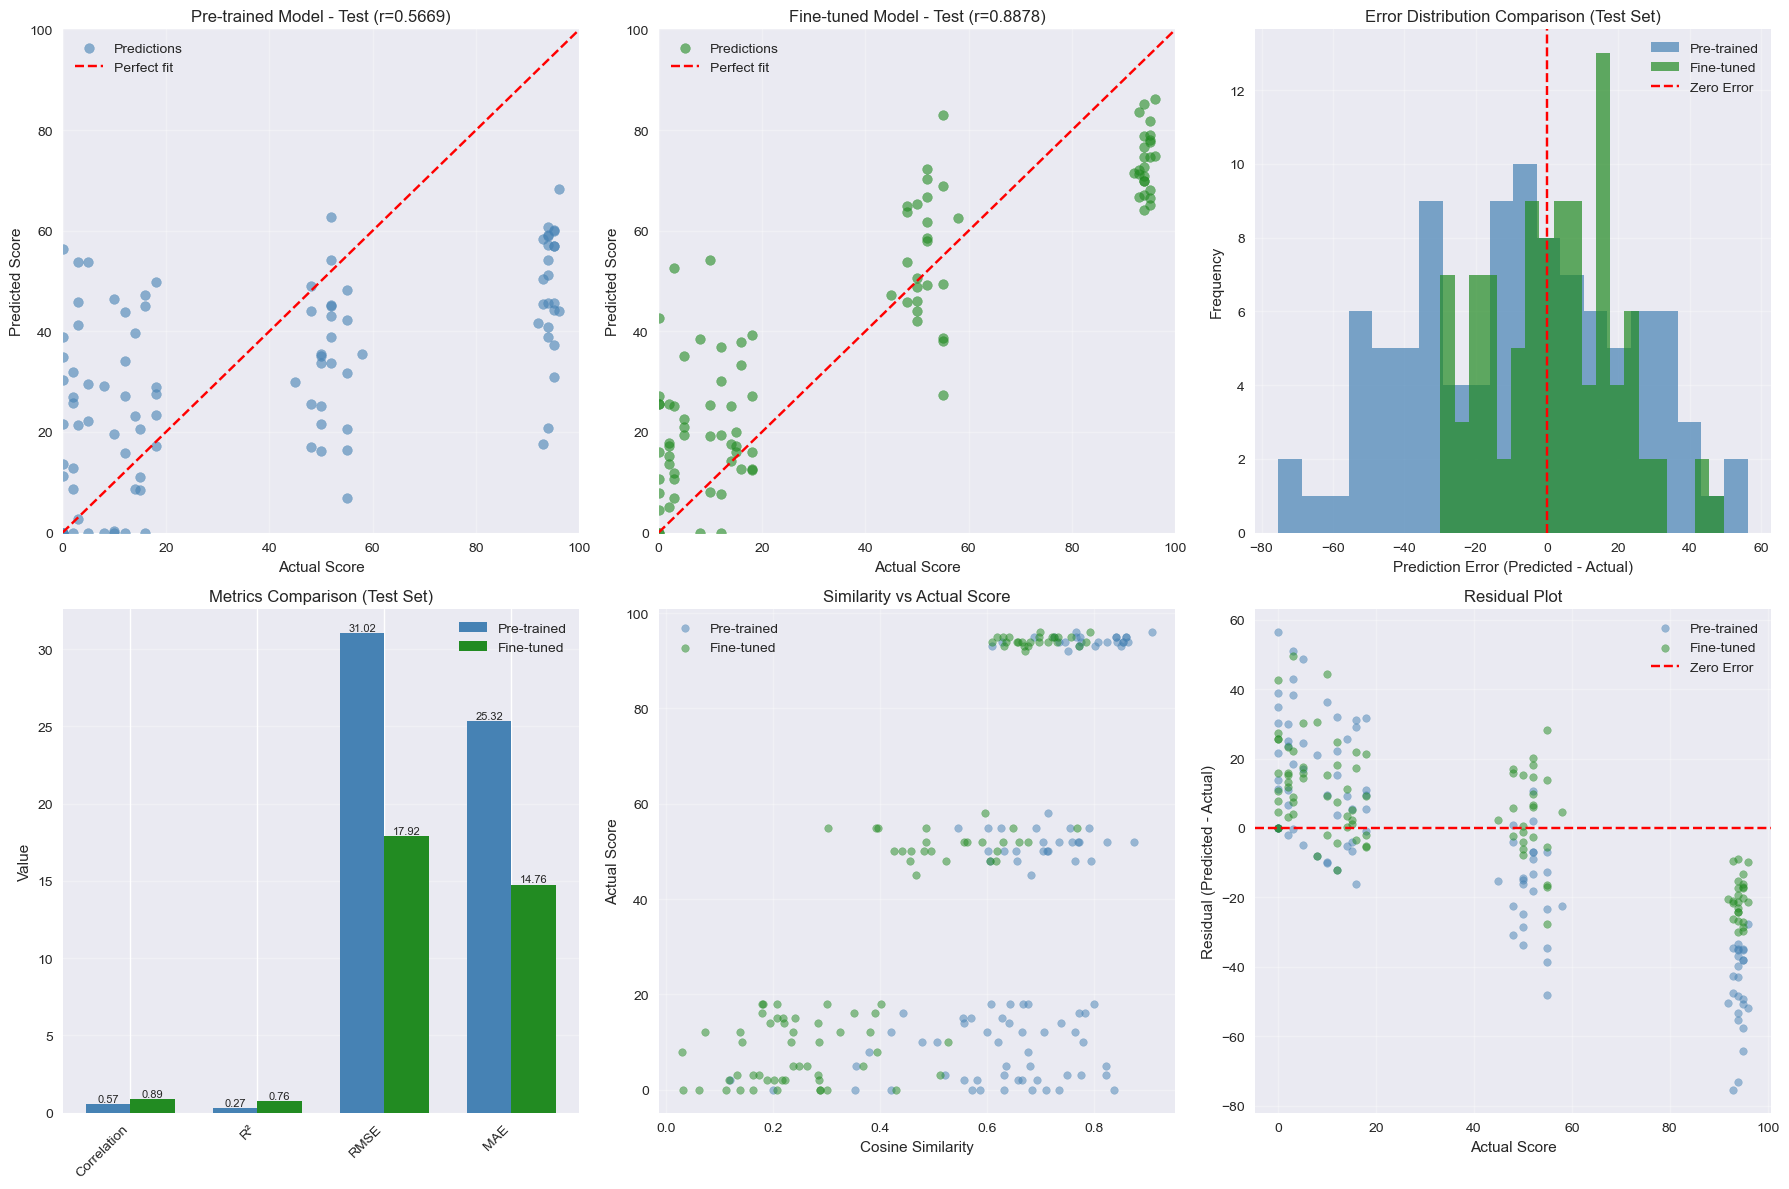


📊 Visualization saved to: model_comparison_improved.png


In [28]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Pre-trained Scatter (Test)
axes[0, 0].scatter(pretrained_test_results['actuals'], pretrained_test_results['predictions'],
                   alpha=0.6, c='steelblue', label='Predictions')
axes[0, 0].plot([0, 100], [0, 100], 'r--', label='Perfect fit')
axes[0, 0].set_xlabel('Actual Score')
axes[0, 0].set_ylabel('Predicted Score')
axes[0, 0].set_title(f'Pre-trained Model - Test (r={pretrained_test_results["correlation"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_ylim(0, 100)

# Plot 2: Fine-tuned Scatter (Test)
axes[0, 1].scatter(finetuned_test_results['actuals'], finetuned_test_results['predictions'],
                   alpha=0.6, c='forestgreen', label='Predictions')
axes[0, 1].plot([0, 100], [0, 100], 'r--', label='Perfect fit')
axes[0, 1].set_xlabel('Actual Score')
axes[0, 1].set_ylabel('Predicted Score')
axes[0, 1].set_title(f'Fine-tuned Model - Test (r={finetuned_test_results["correlation"]:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 100)
axes[0, 1].set_ylim(0, 100)

# Plot 3: Error Distribution
pretrained_errors = pretrained_test_results['predictions'] - pretrained_test_results['actuals']
finetuned_errors = finetuned_test_results['predictions'] - finetuned_test_results['actuals']

axes[0, 2].hist(pretrained_errors, bins=20, alpha=0.7, label='Pre-trained', color='steelblue')
axes[0, 2].hist(finetuned_errors, bins=20, alpha=0.7, label='Fine-tuned', color='forestgreen')
axes[0, 2].axvline(x=0, color='red', linestyle='--', label='Zero Error')
axes[0, 2].set_xlabel('Prediction Error (Predicted - Actual)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Error Distribution Comparison (Test Set)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Metrics Comparison Bar Chart
metrics = ['Correlation', 'R²', 'RMSE', 'MAE']
pretrained_vals = [pretrained_test_results['correlation'], pretrained_test_results['r2'],
                   pretrained_test_results['rmse'], pretrained_test_results['mae']]
finetuned_vals = [finetuned_test_results['correlation'], finetuned_test_results['r2'],
                  finetuned_test_results['rmse'], finetuned_test_results['mae']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, pretrained_vals, width, label='Pre-trained', color='steelblue')
bars2 = axes[1, 0].bar(x + width/2, finetuned_vals, width, label='Fine-tuned', color='forestgreen')

axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Metrics Comparison (Test Set)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, pretrained_vals):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, finetuned_vals):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=8)

# Plot 5: Similarity vs Score relationship
axes[1, 1].scatter(pretrained_test_results['similarities'], pretrained_test_results['actuals'],
                   alpha=0.5, c='steelblue', label='Pre-trained', s=30)
axes[1, 1].scatter(finetuned_test_results['similarities'], finetuned_test_results['actuals'],
                   alpha=0.5, c='forestgreen', label='Fine-tuned', s=30)
axes[1, 1].set_xlabel('Cosine Similarity')
axes[1, 1].set_ylabel('Actual Score')
axes[1, 1].set_title('Similarity vs Actual Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Residual plot
pretrained_residuals = pretrained_test_results['predictions'] - pretrained_test_results['actuals']
finetuned_residuals = finetuned_test_results['predictions'] - finetuned_test_results['actuals']

axes[1, 2].scatter(pretrained_test_results['actuals'], pretrained_residuals,
                   alpha=0.5, c='steelblue', label='Pre-trained', s=30)
axes[1, 2].scatter(finetuned_test_results['actuals'], finetuned_residuals,
                   alpha=0.5, c='forestgreen', label='Fine-tuned', s=30)
axes[1, 2].axhline(y=0, color='red', linestyle='--', label='Zero Error')
axes[1, 2].set_xlabel('Actual Score')
axes[1, 2].set_ylabel('Residual (Predicted - Actual)')
axes[1, 2].set_title('Residual Plot')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to: model_comparison_improved.png")


## 11. Error Analysis


In [29]:
# Error analysis
print("=" * 70)
print("ERROR ANALYSIS - Fine-tuned Model (Test Set)")
print("=" * 70)

# Calculate errors
errors = finetuned_test_results['predictions'] - finetuned_test_results['actuals']
abs_errors = np.abs(errors)

# Find worst predictions
worst_indices = np.argsort(abs_errors)[-10:][::-1]

print("\nTop 10 Worst Predictions:")
print("-" * 70)
for i, idx in enumerate(worst_indices, 1):
    row = test_df.iloc[idx]
    actual = finetuned_test_results['actuals'][idx]
    predicted = finetuned_test_results['predictions'][idx]
    error = errors[idx]

    print(f"\n{i}. Error: {error:.2f} (Predicted: {predicted:.2f}, Actual: {actual:.2f})")
    print(f"   Question: {row['question'][:80]}...")
    print(f"   Key Answer: {row['key_answer'][:100]}...")
    print(f"   Student Answer: {row['student_answer'][:100]}...")

# Error by score range
print("\n" + "=" * 70)
print("Error Statistics by Score Range:")
print("-" * 70)

test_df_copy = test_df.copy()
test_df_copy['predicted'] = finetuned_test_results['predictions']
test_df_copy['actual'] = finetuned_test_results['actuals']
test_df_copy['error'] = errors
test_df_copy['abs_error'] = abs_errors

# Create score bins
test_df_copy['score_bin'] = pd.cut(test_df_copy['actual'], bins=[0, 25, 50, 75, 100], labels=['0-25', '25-50', '50-75', '75-100'])

error_by_bin = test_df_copy.groupby('score_bin')['abs_error'].agg(['mean', 'std', 'count'])
print(error_by_bin)


ERROR ANALYSIS - Fine-tuned Model (Test Set)

Top 10 Worst Predictions:
----------------------------------------------------------------------

1. Error: 49.54 (Predicted: 52.54, Actual: 3.00)
   Question: What is zero-based budgeting and how does it work?...
   Key Answer: Zero-based budgeting means allocating every unit of income to a specific purpose so that income minu...
   Student Answer: Zero-based budgeting is a mathematical theorem about the properties of numbers equal to zero....

2. Error: 44.24 (Predicted: 54.24, Actual: 10.00)
   Question: Explain the 50/30/20 budgeting rule....
   Key Answer: The 50/30/20 rule divides after-tax income into three categories: 50% for needs (essential expenses ...
   Student Answer: The 50/30/20 rule applies to gross income before taxes, allocating half to investments and the remai...

3. Error: 42.63 (Predicted: 42.63, Actual: 0.00)
   Question: What is amortization in loan repayment?...
   Key Answer: Amortization is the process of paying 

## 12. Test dengan Contoh Baru


In [30]:
# Test dengan contoh baru
test_cases = [
    {
        "case": "Perfect Answer",
        "key_answer": "The 50/30/20 rule divides after-tax income into three categories: 50% for needs, 30% for wants, and 20% for savings and debt repayment.",
        "student_answer": "According to the 50/30/20 budgeting guideline, your take-home pay should be allocated as follows: half for essential needs, 30 percent for discretionary spending, and the remaining 20 percent for saving and paying off debts."
    },
    {
        "case": "Partial Answer",
        "key_answer": "Compound interest is interest earned on both the original principal and the accumulated interest from previous periods.",
        "student_answer": "Compound interest means the bank pays you interest on your money."
    },
    {
        "case": "Wrong Answer",
        "key_answer": "PTKP is the portion of income that is not taxed. PKP is the taxable income after subtracting PTKP.",
        "student_answer": "PTKP is a type of Indonesian food and PKP is a traditional dance."
    }
]

print("=" * 80)
print("TESTING DENGAN CONTOH BARU")
print("=" * 80)

for test in test_cases:
    # Pre-trained prediction
    emb_pre = pretrained_model.encode([test['key_answer'], test['student_answer']], convert_to_tensor=True)
    sim_pre = util.cos_sim(emb_pre[0], emb_pre[1]).item()
    score_pre = pretrained_score_converter.predict([[sim_pre]])[0]
    score_pre = np.clip(score_pre, 0, 100)

    # Fine-tuned prediction
    emb_fine = finetuned_model.encode([test['key_answer'], test['student_answer']], convert_to_tensor=True)
    sim_fine = util.cos_sim(emb_fine[0], emb_fine[1]).item()
    score_fine = finetuned_score_converter.predict([[sim_fine]])[0]
    score_fine = np.clip(score_fine, 0, 100)

    print(f"\n📌 Case: {test['case']}")
    print(f"   Key Answer:     {test['key_answer'][:60]}...")
    print(f"   Student Answer: {test['student_answer'][:60]}...")
    print(f"   Pre-trained Score:  {score_pre:.2f} (similarity: {sim_pre:.4f})")
    print(f"   Fine-tuned Score:   {score_fine:.2f} (similarity: {sim_fine:.4f})")
    print(f"   Difference:         {(score_fine - score_pre):+.2f}")


TESTING DENGAN CONTOH BARU

📌 Case: Perfect Answer
   Key Answer:     The 50/30/20 rule divides after-tax income into three catego...
   Student Answer: According to the 50/30/20 budgeting guideline, your take-hom...
   Pre-trained Score:  16.05 (similarity: 0.6005)
   Fine-tuned Score:   74.77 (similarity: 0.6982)
   Difference:         +58.72

📌 Case: Partial Answer
   Key Answer:     Compound interest is interest earned on both the original pr...
   Student Answer: Compound interest means the bank pays you interest on your m...
   Pre-trained Score:  51.29 (similarity: 0.8081)
   Fine-tuned Score:   51.80 (similarity: 0.5065)
   Difference:         +0.51

📌 Case: Wrong Answer
   Key Answer:     PTKP is the portion of income that is not taxed. PKP is the ...
   Student Answer: PTKP is a type of Indonesian food and PKP is a traditional d...
   Pre-trained Score:  20.81 (similarity: 0.6285)
   Fine-tuned Score:   1.71 (similarity: 0.0885)
   Difference:         -19.09


## 13. Kesimpulan dan Rekomendasi


In [ ]:
print("\n" + "=" * 70)
print("KESIMPULAN")
print("=" * 70)

if finetuned_test_results['correlation'] > pretrained_test_results['correlation']:
    print("\n✅ Fine-tuned model LEBIH BAIK dari pre-trained model!")
    print(f"   Correlation meningkat: {pretrained_test_results['correlation']:.4f} → {finetuned_test_results['correlation']:.4f}")
    print(f"   R² Score meningkat: {pretrained_test_results['r2']:.4f} → {finetuned_test_results['r2']:.4f}")
    print(f"   RMSE menurun: {pretrained_test_results['rmse']:.4f} → {finetuned_test_results['rmse']:.4f}")
    recommendation = "Gunakan fine-tuned model untuk deployment"
else:
    print("\n⚠️  Pre-trained model masih lebih baik atau sama.")
    print("   Mungkin perlu:")
    print("   - Dataset training yang lebih besar")
    print("   - Lebih banyak epochs")
    print("   - Hyperparameter tuning")
    recommendation = "Pertimbangkan untuk menambah data atau epochs"

print(f"\n📋 Rekomendasi: {recommendation}")
print(f"\n📁 Model tersimpan di: {OUTPUT_PATH}")


KESIMPULAN

✅ Fine-tuned model LEBIH BAIK dari pre-trained model!
   Correlation meningkat: 0.5669 → 0.8878
   R² Score meningkat: 0.2662 → 0.7552
   RMSE menurun: 31.0217 → 17.9197

📋 Rekomendasi: Gunakan fine-tuned model untuk deployment

📁 Model tersimpan di: ./finsmart-ai-finetuned-model

PERBAIKAN YANG DILAKUKAN:
1. ✅ Menambahkan EDA (Exploratory Data Analysis)
2. ✅ Memisahkan Train/Validation/Test set dengan proper
3. ✅ Menambahkan data preprocessing dan cleaning
4. ✅ Menggunakan Linear Regression untuk konversi similarity ke score
5. ✅ Menambahkan R² Score sebagai metrik tambahan
6. ✅ Menambahkan error analysis yang lebih mendalam
7. ✅ Menggunakan validation set untuk evaluasi selama training
8. ✅ Menambahkan residual plot dan analisis bias
9. ✅ Visualisasi yang lebih lengkap

